# Linear Regression

In [11]:
#read the file
df = pd.read_json (r'SIRI.json')

#print the head
df

,c,h,l,o,s,t,v
0,6.95,7.00,6.94,6.96,ok,1534167000,9981200
1,6.96,7.01,6.95,6.95,ok,1534253400,11320000
2,6.90,6.96,6.84,6.94,ok,1534339800,12260900
3,6.94,7.01,6.93,6.93,ok,1534426200,9581200
4,6.97,7.02,6.91,6.94,ok,1534512600,11454400
...,...,...,...,...,...,...,...
407,5.20,5.35,5.07,5.07,ok,1585229400,27208100
408,4.93,5.06,4.90,5.04,ok,1585315800,24632800
409,4.81,5.08,4.76,4.96,ok,1585575000,34793000
410,4.94,5.12,4.80,4.84,ok,1585661400,29402000


In [12]:
X = df[['t']]
y = df['c'].values.reshape(-1, 1)
print(X.shape, y.shape)

(412, 1) (412, 1)


In [13]:
data = X.copy()

data_binary_encoded = pd.get_dummies(data)
data_binary_encoded.head()

,t
0,1534167000
1,1534253400
2,1534339800
3,1534426200
4,1534512600


In [14]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

,t
104,1547217000
287,1570109400
403,1584711000
237,1563975000
231,1563283800


In [15]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [16]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

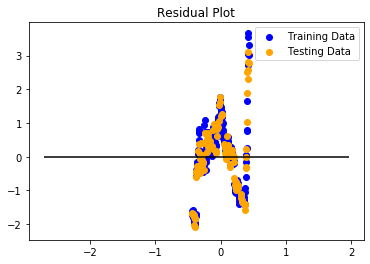

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [32]:
predictions = model.predict(X_test_scaled)
predictions

array([[ 0.13617888],
       [-0.32604245],
       [ 0.06473142],
       [-0.37270202],
       [ 0.16534111],
       [ 0.3476658 ],
       [ 0.10555854],
       [-0.21079089],
       [ 0.09535176],
       [-0.00817415],
       [-0.37707635],
       [ 0.11430721],
       [ 0.32141979],
       [-0.26619913],
       [-0.28661269],
       [-0.32458434],
       [ 0.20762634],
       [ 0.17263167],
       [ 0.21643577],
       [-0.2749478 ],
       [ 0.37099558],
       [-0.42373592],
       [ 0.42925928],
       [-0.29536136],
       [ 0.02536241],
       [-0.199126  ],
       [ 0.32725224],
       [ 0.31704546],
       [ 0.38995103],
       [-0.04900127],
       [ 0.42196873],
       [-0.05774994],
       [-0.27640591],
       [ 0.20471012],
       [ 0.16242489],
       [ 0.22955877],
       [ 0.21497765],
       [-0.17142188],
       [-0.40769669],
       [ 0.31558734],
       [-0.43977515],
       [-0.05629183],
       [ 0.26746967],
       [ 0.07639631],
       [ 0.27038589],
       [ 0

In [ ]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

In [ ]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

In [ ]:
#make predictions and find the rmse
preds = model.predict(X_test_scaled)
rms=np.sqrt(np.mean(np.power((np.array(y_test_scaled)-np.array(preds)),2)))
rms

In [33]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.2252289232218518, R2: -0.09345626029037213


In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[987:].index
train.index = new_data[:987].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

# K-Nearest Neighbours

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [19]:
#read the file
df = pd.read_json (r'SIRI.json')

#print the head
df

,c,h,l,o,s,t,v
0,6.95,7.00,6.94,6.96,ok,1534167000,9981200
1,6.96,7.01,6.95,6.95,ok,1534253400,11320000
2,6.90,6.96,6.84,6.94,ok,1534339800,12260900
3,6.94,7.01,6.93,6.93,ok,1534426200,9581200
4,6.97,7.02,6.91,6.94,ok,1534512600,11454400
...,...,...,...,...,...,...,...
407,5.20,5.35,5.07,5.07,ok,1585229400,27208100
408,4.93,5.06,4.90,5.04,ok,1585315800,24632800
409,4.81,5.08,4.76,4.96,ok,1585575000,34793000
410,4.94,5.12,4.80,4.84,ok,1585661400,29402000


In [20]:
X = df.t
y = df.c

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train.reshape(-1, 1))

In [ ]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

In [22]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
#scaling data
x_train_scaled = scaler.fit_transform(X_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(X_test)
x_valid = pd.DataFrame(x_test_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_test)

In [ ]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

In [23]:
# Predictor variables
df['Open-Close']= df.o -df.c
df['High-Low']  = df.h - df.l
df =df.dropna()
X= df[['Open-Close', 'High-Low']]
X.head()

,Open-Close,High-Low
0,0.01,0.06
1,-0.01,0.06
2,0.04,0.12
3,-0.01,0.08
4,-0.03,0.11


In [24]:
# Target variable
Y= np.where(df['c'].shift(-1)>df['c'],1,-1)

In [25]:
# Splitting the dataset
split_percentage = 0.7
split = int(split_percentage*len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [28]:
# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model
knn.fit(X_train, Y_train)

# Accuracy Score
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.63
Test_data Accuracy: 0.50


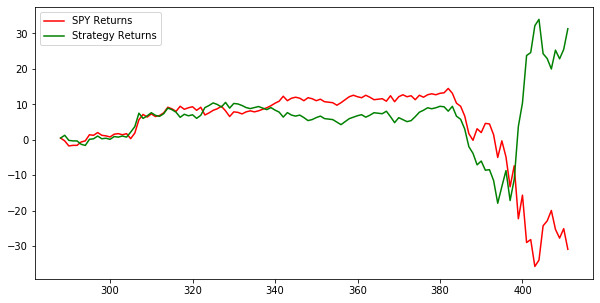

In [30]:
# Predicted Signal
df['Predicted_Signal'] = knn.predict(X)

# SPY Cumulative Returns
df['SPY_returns'] = np.log(df['c']/df['c'].shift(1))
Cumulative_SPY_returns = df[split:]['SPY_returns'].cumsum()*100

# Cumulative Strategy Returns 
df['Startegy_returns'] = df['SPY_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100

# Plot the results to visualize the performance

plt.figure(figsize=(10,5))
plt.plot(Cumulative_SPY_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [31]:
# Calculate Sharpe reatio
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_SPY_returns)/Std
Sharpe = Sharpe.mean()
print ('Sharpe ratio: %.2f'%Sharpe )

Sharpe ratio: 0.31


# Auto ARIMA

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
#read the file
df = pd.read_json (r'SIRI.json')

#print the head
df

,c,h,l,o,s,t,v
0,6.95,7.00,6.94,6.96,ok,1534167000,9981200
1,6.96,7.01,6.95,6.95,ok,1534253400,11320000
2,6.90,6.96,6.84,6.94,ok,1534339800,12260900
3,6.94,7.01,6.93,6.93,ok,1534426200,9581200
4,6.97,7.02,6.91,6.94,ok,1534512600,11454400
...,...,...,...,...,...,...,...
407,5.20,5.35,5.07,5.07,ok,1585229400,27208100
408,4.93,5.06,4.90,5.04,ok,1585315800,24632800
409,4.81,5.08,4.76,4.96,ok,1585575000,34793000
410,4.94,5.12,4.80,4.84,ok,1585661400,29402000


Text(0.5, 1.0, 'Microsoft Autocorrelation plot')

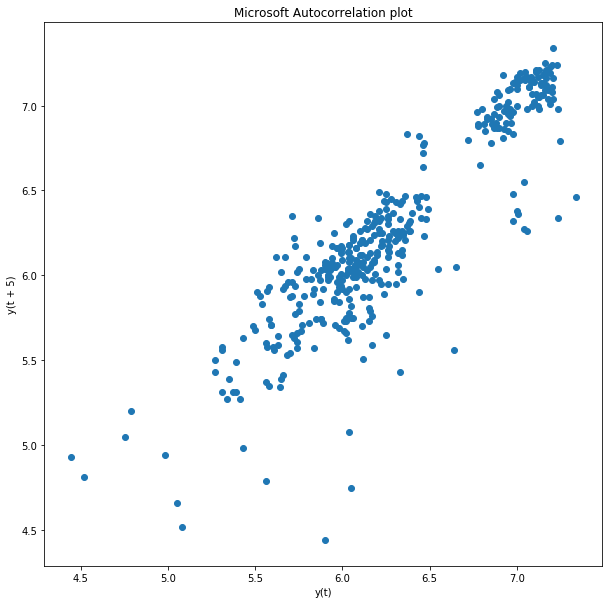

In [4]:
plt.figure(figsize=(10,10))
lag_plot(df['c'], lag=5)
plt.title('Microsoft Autocorrelation plot')

In [5]:
df['t'][411]

1585747800

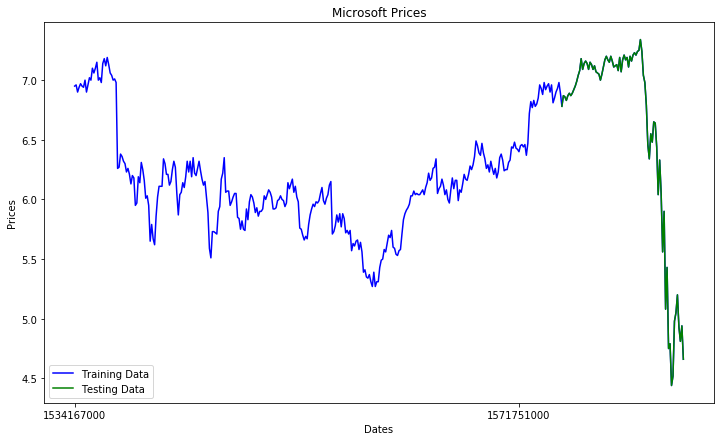

In [6]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Microsoft Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['c'], 'blue', label='Training Data')
plt.plot(test_data['c'], 'green', label='Testing Data')
plt.xticks(np.arange(0,411, 300), df['t'][0:411:300])
plt.legend()

In [7]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))

In [8]:
train_ar = train_data['c'].values
test_ar = test_data['c'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 0.035
Symmetric mean absolute percentage error: 12.569


In [9]:
pd.DataFrame({"Prediction": predictions, 'Actual': test_ar})

,Prediction,Actual
0,[6.893045059838072],6.78
1,[6.787690157724871],6.87
2,[6.868924265142332],6.86
3,[6.865206004527933],6.83
4,[6.8298774877577255],6.87
...,...,...
78,[5.121866063680507],5.20
79,[5.169776297833784],4.93
80,[4.97324672000541],4.81
81,[4.81324569100674],4.94


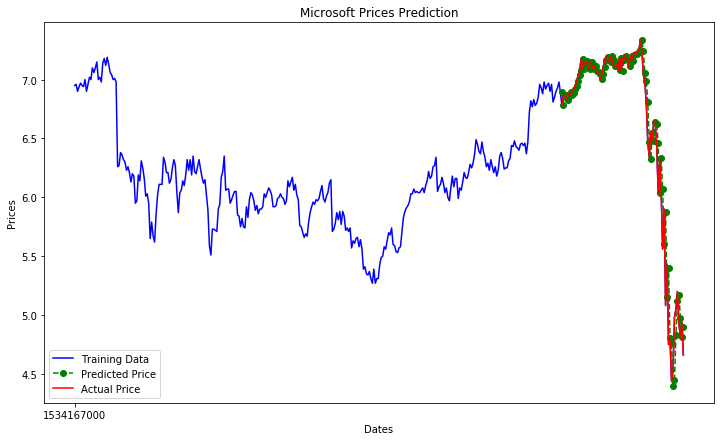

In [10]:
plt.figure(figsize=(12,7))
plt.plot(df['c'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['c'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,412, 1300), df['t'][0:412:1300])
plt.legend()

# Prophet

In [ ]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:987]
valid = new_data[987:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [ ]:
#rmse
forecast_valid = forecast['yhat'][987:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

# Long Short Term Memory

In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['t', 'c'])
for i in range(0,len(data)):
    new_data['t'][i] = data['c'][i]
    new_data['c'][i] = data['c'][i]

#setting index
new_data.index = new_data.t
new_data.drop('t', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [ ]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['c'])
plt.plot(valid[['Close','Predictions']])